## Sequntial API

사용할 패키지를 불러옵니다.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from utils import standard_scaling, R_squared, train_val_split
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

캘리포니아 집값 데이터 클래스를 불러옵니다.

In [2]:
housing = fetch_california_housing()

데이터를 훈련, 검증, 테스트 데이터로 나눕니다.

In [3]:
x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full)

입력값들을 정규화 시켜줍니다.

In [4]:
x_train = standard_scaling(x_train)
x_val = standard_scaling(x_val)
x_test = standard_scaling(x_test)

신경망의 시퀀스를 만드는 함수로 ```keras.models.Sequntial()```를 사용합니다.

In [5]:
model = keras.models.Sequential([
    keras.layers.Dense(30, # 30개의 유닛이 있는 은닉층
                       activation="relu", # 해당 은닉층의 활성화 함수는 relu를 사용함
                       input_shape=x_train.shape[1:] # 입력층을 따로 지정하지 않고 바로 사용
                      ), 
    keras.layers.Dense(1) # 출력값은 1개 이므로 유닛이 1개인 출력층을 만듦
])

만들어진 시퀀스 모델의 구조를 확인합니다.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


사용자 정의 콜백 만들기

https://www.tensorflow.org/guide/keras/custom_callback

In [23]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print( "\nval/train: {:.2f}".format(logs["val_loss"]/logs["loss"]))

구조가 확정된 모델의 학습방법을 지정하고 학습을 진행합니다.  
추가적으로 모델의 과대적합을 피하기 위한 조기종료, 체크 포인트 콜백을 추가합니다.

In [25]:
model.compile(loss="mean_squared_error", # 손실함수로는 평균제곱오차를 사용
              optimizer="sgd" # 최적화기법으로 확률적 경사하강법 사용
             )  


early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, # 3번까지 모델이 향상도지 않으면 조기종료
                                                  restore_best_weights=True # 훈련이 끝난 후 최상의 가중치 복원
                                                 )
checkpoint_cb = keras.callbacks.ModelCheckpoint("./save_models/my_keras_model.h5", # 체크포인트의 모델명 지정
                                               save_best_only=True # 최상의 검증 세트 점수에서만 모델을 저장
                                               )

history = model.fit(x_train, # 입력변수
                    y_train, # 출력변수
                    epochs=100, # 전체 데이터 학습 횟수
                    validation_data=(x_val, y_val), # 에폭마다 검증 데이터 결과 출력
                    callbacks=[early_stopping_cb, checkpoint_cb], # 조기종료, 체크 포인트 콜백 사용
                    verbose = 0
                   )

mse_test = model.evaluate(x_test, y_test) # 완성된 모델의 테스트 데이터 결과 출력

162/162 [==============================] - 0s 3ms/step - loss: 0.3961


모델이 학습 잘 학습되어지는지 에폭마다 손실함수 값을 확인합니다.

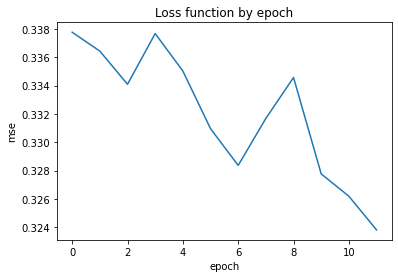

In [26]:
plt.plot(history.history["loss"])
plt.title("Loss function by epoch")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

학습된 모델의 성능 검증을 위하여 결정계수를 구합니다.

In [27]:
pred_y = model.predict(x_test)
y_test = y_test.reshape(-1,1)
evaluate = R_squared(pred_y, y_test) # 결정계수
evaluate

0.7024304839071723

텐서보드 콜백을 활용한 모델의 학습 로그를 폴더로 저장합니다.

In [45]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

In [46]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir) # 텐서보드 콜백으로 시간단위 로그 저장

model.compile(loss="mean_squared_error", # 손실함수로는 평균제곱오차를 사용
              optimizer="sgd" # 최적화기법으로 확률적 경사하강법 사용
             )  


early_stopping_cb = keras.callbacks.EarlyStopping(patience=4, # 3번까지 모델이 향상도지 않으면 조기종료
                                                  restore_best_weights=True # 훈련이 끝난 후 최상의 가중치 복원
                                                 )
checkpoint_cb = keras.callbacks.ModelCheckpoint("./save_models/my_keras_model.h5", # 체크포인트의 모델명 지정
                                               save_best_only=True # 최상의 검증 세트 점수에서만 모델을 저장
                                               )

history = model.fit(x_train, # 입력변수
                    y_train, # 출력변수
                    epochs=100, # 전체 데이터 학습 횟수
                    validation_data=(x_val, y_val), # 에폭마다 검증 데이터 결과 출력
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb], # 조기종료, 체크 포인트 콜백 사용
                    verbose = 0
                   )

mse_test = model.evaluate(x_test, y_test) # 완성된 모델의 테스트 데이터 결과 출력

162/162 [==============================] - 0s 3ms/step - loss: 0.3824


텐서보드 서버를 시작하는 방법은 2가지 입니다.  
쉘에서 tensorboard --logdir=./my_logs --port==6006

주피터 노트북에서 텐서보드 가져오는 방법입니다.

In [47]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs/ --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 17904.

모델 저장하기

In [10]:
model.save("./save_models/ex1.h5")

모델 불러오기

In [17]:
from tensorflow.keras.models import load_model
load_model1 = load_model("./save_models/ex1.h5")
load_model2 = load_model("./save_models/my_keras_model.h5")

불러온 모델 확인하기

In [18]:
pred_y1 = load_model1.predict(x_test)
pred_y2 = load_model2.predict(x_test)
y_test = y_test.reshape(-1,1)
evaluate1 = R_squared(pred_y1, y_test) # 결정계수
evaluate2 = R_squared(pred_y2, y_test) # 결정계수
evaluate1, evaluate2

(0.7031702350055977, 0.698514892188876)